# 01 — Exploratory Data Analysis (NFL)

Goals:
- Verify data availability and basic quality.
- Produce baseline summaries (teams, weeks, seasons).
- Visualize simple trends (pass rate, EPA).
- Identify obvious feature ideas and gaps.

In [8]:
# Install plotting and project requirements (robust path)
import sys, subprocess
from pathlib import Path

# Optional plotting libs
subprocess.run([sys.executable, '-m', 'pip', 'install', '-q', 'seaborn', 'matplotlib'], check=False)

# Try requirements at repo root or parent
candidates = [Path('requirements.txt'), Path('..')/'requirements.txt']
req = next((p for p in candidates if p.exists()), None)
print('Using requirements at:', req if req else 'None found')
if req:
    subprocess.run([sys.executable, '-m', 'pip', 'install', '-q', '-r', str(req)], check=False)

import os
try:
    import certifi
    os.environ.setdefault('SSL_CERT_FILE', certifi.where())
except Exception:
    pass
print('SSL_CERT_FILE=', os.environ.get('SSL_CERT_FILE',''))


Using requirements at: ../requirements.txt
SSL_CERT_FILE= /Users/aksharravichandran/Documents/GitHub/NFLAnalytics/.venv/lib/python3.12/site-packages/certifi/cacert.pem


In [9]:
import os, sys, textwrap
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

# SSL certs (avoid SSL issues when fetching in-notebook)
try:
    import certifi
    os.environ.setdefault('SSL_CERT_FILE', certifi.where())
except Exception:
    pass

# Optional plotting style
try:
    import seaborn as sns
    sns.set_context('talk')
    sns.set_style('whitegrid')
except Exception:
    sns = None

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 160)

print('Python:', sys.version.split()[0])
print('SSL_CERT_FILE=', os.environ.get('SSL_CERT_FILE', ''))

Python: 3.12.5
SSL_CERT_FILE= /Users/aksharravichandran/Documents/GitHub/NFLAnalytics/.venv/lib/python3.12/site-packages/certifi/cacert.pem


In [10]:
# Parameters
DATA_ROOT = Path('../data/raw')
YEARS = list(range(2019, 2025))  # adjust as needed

def find_latest_file(subdir: str, prefix: str, exts=('csv','parquet')):
    d = DATA_ROOT / subdir
    if not d.exists():
        return None
    cands = []
    for ext in exts:
        cands.extend(d.glob(f'{prefix}*.{ext}'))
    if not cands:
        return None
    return sorted(cands)[-1]

def read_any(path: Path, columns=None):
    if path is None:
        return None
    try:
        if path.suffix == '.parquet':
            return pd.read_parquet(path, columns=columns)
        return pd.read_csv(path, usecols=columns)
    except Exception as e:
        print('Failed to read', path, e)
        return None

def show_shape(name, df):
    if df is None:
        print(f'{name}: MISSING')
    else:
        mb = (df.memory_usage(index=True, deep=True).sum())/1e6
        print(f'{name}: shape={df.shape}, ~{mb:.1f} MB')

list(DATA_ROOT.glob('*'))[:5]  # quick peek

[PosixPath('../data/raw/depth_charts'),
 PosixPath('../data/raw/snap_counts'),
 PosixPath('../data/raw/team_desc'),
 PosixPath('../data/raw/schedules'),
 PosixPath('../data/raw/pbp')]

In [11]:
# Load key datasets (if present)
sched_f = find_latest_file('schedules', 'schedules_')
weekly_f = find_latest_file('weekly', 'weekly_')
seasonal_f = find_latest_file('seasonal', 'seasonal_')
pbp_f = find_latest_file('pbp', 'pbp_')
inj_f = find_latest_file('injuries', 'injuries_')
depth_f = find_latest_file('depth_charts', 'depth_charts_')
snap_f = find_latest_file('snap_counts', 'snap_counts_')

sched = read_any(sched_f, columns=['season','week','game_id','home_team','away_team','result','home_score','away_score','gameday'])
weekly = read_any(weekly_f)
seasonal = read_any(seasonal_f)
# Read a minimal subset of PBP for performance
pbp_cols = ['season','week','game_id','posteam','defteam','epa','pass','rush','down','ydstogo']
pbp = read_any(pbp_f, columns=pbp_cols)

show_shape('schedules', sched)
show_shape('weekly', weekly)
show_shape('seasonal', seasonal)
show_shape('pbp (subset)', pbp)
show_shape('injuries', read_any(inj_f))
show_shape('depth_charts', read_any(depth_f))
show_shape('snap_counts', read_any(snap_f))


schedules: shape=(1675, 9), ~0.4 MB
weekly: shape=(33287, 53), ~28.6 MB
seasonal: shape=(3716, 58), ~1.9 MB
pbp (subset): shape=(293478, 10), ~63.4 MB
injuries: shape=(34136, 16), ~23.1 MB
depth_charts: shape=(222382, 15), ~160.0 MB
snap_counts: shape=(154865, 16), ~78.3 MB


In [12]:
# Basic summaries
if sched is not None:
    display(sched.head())
    print('Games by season:')
    display(sched.groupby('season').size().rename('games').to_frame())

if weekly is not None:
    num_cols = [c for c in weekly.columns if weekly[c].dtype.kind in 'if']
    print('Weekly numeric columns:', len(num_cols))
    display(weekly[['season','week']].value_counts().sort_index().head(10))

if seasonal is not None:
    print('Seasonal columns:', seasonal.shape[1])
    display(seasonal.groupby('season').size().rename('rows').to_frame().head())

if pbp is not None:
    print('EPA summary (all plays):')
    display(pbp['epa'].describe(percentiles=[.1,.5,.9]))
    print('Success rate (epa>0) by season (head):')
    sr = pbp.assign(success=(pbp['epa']>0).astype(int)).groupby('season')['success'].mean().to_frame('success_rate')
    display(sr.head())


,season,week,game_id,home_team,away_team,result,home_score,away_score,gameday
0,2019,1,2019_01_GB_CHI,CHI,GB,-7.0,3.0,10.0,2019-09-05
1,2019,1,2019_01_LA_CAR,CAR,LA,-3.0,27.0,30.0,2019-09-08
2,2019,1,2019_01_TEN_CLE,CLE,TEN,-30.0,13.0,43.0,2019-09-08
3,2019,1,2019_01_KC_JAX,JAX,KC,-14.0,26.0,40.0,2019-09-08
4,2019,1,2019_01_BAL_MIA,MIA,BAL,-49.0,10.0,59.0,2019-09-08


Games by season:


,games
season,
2019,267
2020,269
2021,285
2022,284
2023,285
2024,285


Weekly numeric columns: 44


season  week
2019    1       310
        2       314
        3       308
        4       286
        5       288
        6       278
        7       288
        8       298
        9       271
        10      250
Name: count, dtype: int64

Seasonal columns: 58


,rows
season,
2019,613
2020,634
2021,655
2022,619
2023,588


EPA summary (all plays):


count    290117.000000
mean         -0.005626
std           1.258814
min         -13.584859
10%          -1.133134
50%           0.000000
90%           1.410914
max           8.882384
Name: epa, dtype: float64

Success rate (epa>0) by season (head):


,success_rate
season,
2019,0.402264
2020,0.419621
2021,0.408197
2022,0.405874
2023,0.396094


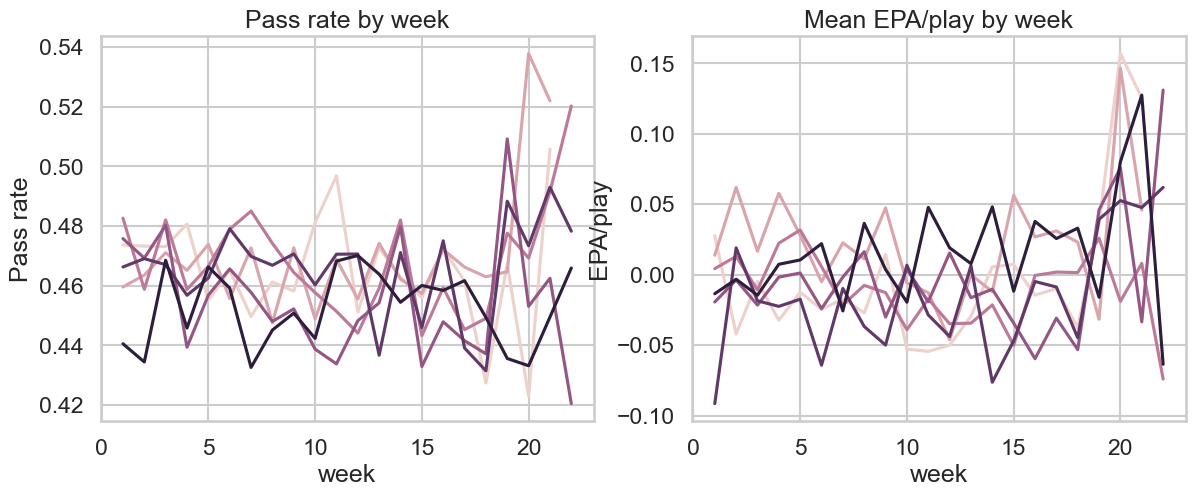

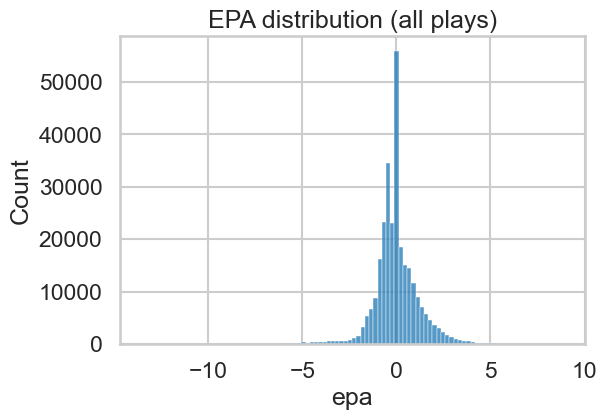

In [13]:
# Visuals — pass rate over time, EPA distribution
if pbp is not None:
    agg = (pbp.groupby(['season','week'])
              .agg(pass_rate=('pass','mean'),
                   epa_mean=('epa','mean'))
              .reset_index())
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    if sns:
        sns.lineplot(data=agg, x='week', y='pass_rate', hue='season', ax=ax[0], legend=False)
        sns.lineplot(data=agg, x='week', y='epa_mean', hue='season', ax=ax[1], legend=False)
    else:
        for s, g in agg.groupby('season'):
            ax[0].plot(g['week'], g['pass_rate'], alpha=.6)
            ax[1].plot(g['week'], g['epa_mean'], alpha=.6)
    ax[0].set_title('Pass rate by week')
    ax[1].set_title('Mean EPA/play by week')
    ax[0].set_ylabel('Pass rate')
    ax[1].set_ylabel('EPA/play')
    plt.show()

    fig, ax = plt.subplots(figsize=(6,4))
    if sns:
        sns.histplot(pbp['epa'].dropna(), bins=100, ax=ax)
    else:
        ax.hist(pbp['epa'].dropna(), bins=100)
    ax.set_title('EPA distribution (all plays)')
    plt.show()


,pass_rate
posteam,
CLE,0.552685
CIN,0.539972
LV,0.532431
NYJ,0.529500
KC,0.519112
CHI,0.518570
SEA,0.515346
NYG,0.506016
DAL,0.500000


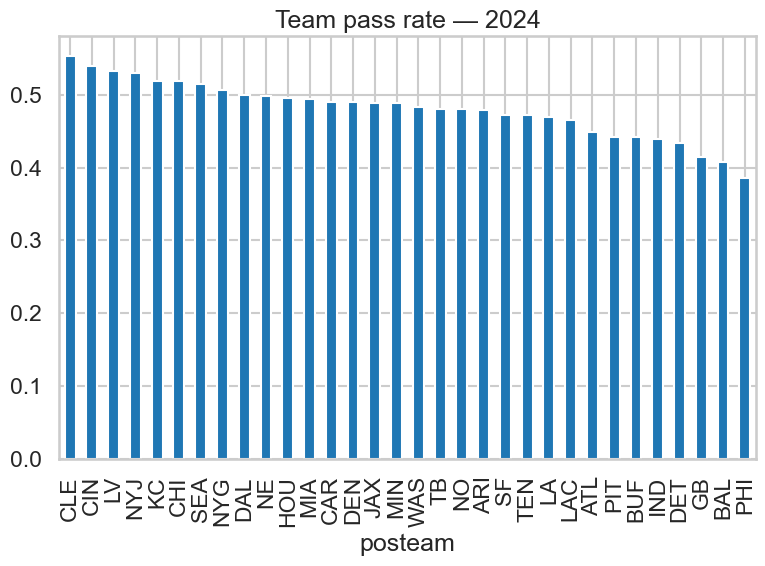

In [14]:
# Team-level pass rate snapshot (last season in range)
if pbp is not None:
    last_season = int(pd.Series(pbp['season'].unique()).max())
    tpr = (pbp.loc[pbp['season'].eq(last_season)]
              .groupby('posteam')['pass']
              .mean()
              .sort_values(ascending=False)
              .to_frame('pass_rate'))
    display(tpr)
    fig, ax = plt.subplots(figsize=(8,6))
    tpr.plot(kind='bar', ax=ax, legend=False, title=f'Team pass rate — {last_season}')
    plt.tight_layout()
    plt.show()


In [15]:
# Data quality checks: null fractions for a few core columns
def null_fraction(df, cols):
    if df is None:
        return pd.DataFrame()
    return (df[cols].isna().mean().rename('null_frac').to_frame()
              .sort_values('null_frac', ascending=False))

if weekly is not None:
    w_cols = [c for c in ['player_id','player_name','team','position','fantasy_points_ppr'] if c in weekly.columns]
    print('Weekly nulls:')
    display(null_fraction(weekly, w_cols))

if sched is not None:
    s_cols = [c for c in ['home_team','away_team','result','home_score','away_score'] if c in sched.columns]
    print('Schedules nulls:')
    display(null_fraction(sched, s_cols))

if pbp is not None:
    p_cols = [c for c in ['epa','posteam','defteam','down','ydstogo'] if c in pbp.columns]
    print('PBP nulls:')
    display(null_fraction(pbp, p_cols))


Weekly nulls:


,null_frac
player_id,0.0
player_name,0.0
position,0.0
fantasy_points_ppr,0.0


Schedules nulls:


,null_frac
home_team,0.0
away_team,0.0
result,0.0
home_score,0.0
away_score,0.0


PBP nulls:


,null_frac
down,0.159579
posteam,0.053769
defteam,0.053769
epa,0.011452
ydstogo,0.000000


In [18]:
# Save lightweight EDA outputs
OUT = Path('../data/eda'); OUT.mkdir(parents=True, exist_ok=True)
if pbp is not None:
    league_trend = (pbp.groupby(['season','week'])
                      .agg(pass_rate=('pass','mean'), epa_mean=('epa','mean'))
                      .reset_index())
    league_trend.to_csv(OUT/'league_trend.csv', index=False)
if sched is not None:
    (sched.groupby('season').size().rename('games').to_frame()
         .to_csv(OUT/'games_by_season.csv'))
print('Saved EDA outputs to', OUT)


Saved EDA outputs to ../data/eda


## Notes / Next ideas
- Add opponent-adjusted rolling EPA features.
- Merge injuries/snap_counts for availability-adjusted usage.
- For modeling: create train/valid/test time-based splits.
- Validate market info (sc_lines) availability timeline to avoid leakage.